In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys

import itertools
import pathlib

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpltools import style
from mpltools import layout
#from networkx import Graph
import seaborn as sns

sys.path.append('..')
import about
import pathcustomize

from waldo.conf import settings
from waldo.wio.experiment import Experiment
from waldo.extern import multiworm 
from multiworm.core import MWTSummaryError
from waldo.output.speed import SpeedWriter
from waldo.output.speed import *
from waldo.wio.worm_writer import WormWriter
from waldo.output.binsize_stats import BinSelfTest, self_bin_experiment

style.use('ggplot')
about.about()

Python 3.4.1 (default, Feb 28 2015 09:14:07) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.56)] on darwin, Host: peters-MacBook-Air.local


In [ ]:
import scipy
scipy.__version__

In [3]:
sys.path.append('../../../pybrary')
from pat_cluster.sort import ClusterMatrix

In [4]:
def make_cdf(a, maxbins=10000):
    x = np.sort(a)
    y = np.linspace(0, 1, len(a))
    return x, y

In [5]:
day_1_eids = [  '20130318_131056',
                '20130318_131111',
                '20130318_131113',
                '20130318_142605',
                '20130318_142613',
                '20130318_153741',
                '20130318_153742',
                '20130318_153749',
                '20130318_165642',
                '20130318_165643',
                '20130318_165649']

In [6]:
def pull_tracks(eid, min_points = 40 * 60):
    sw = SpeedWriter(eid)
    wr = WormWriter(eid)
    typical_bl = sw._experiment.typical_bodylength
    bids = wr.blobs('speed_files')
    all_tracks = {}
    for bid in bids:
        speed_df = wr.load(bid, data_id='speed_files')
        #print speed_df.head()
        #break
        dur = max(speed_df['time']) - min(speed_df['time'])
        #print bid, dur, len(speed_df)
        if dur < min_points:
            continue

        unique_id = '{e}-{b}'.format(e=eid, b=bid)        
        #print unique_id

        norm_speed = np.array(speed_df['speed'] / typical_bl)
        #print norm_speed
        #break
        all_tracks[unique_id] = norm_speed
    return all_tracks
#all_tracks = pull_tracks(eid)

In [7]:
young_tracks = {}
for eid in day_1_eids:
    try:
        eid_tracks = pull_tracks(eid)
        young_tracks.update(eid_tracks)
        print eid, '-', len(eid_tracks), 'tracks'
    except MWTSummaryError:
        print eid, '- skipping'
        
print len(young_tracks), 'young tracks in total'

20130318_131056 - 8 tracks
20130318_131111 - 1 tracks
20130318_131113 - 9 tracks
20130318_142605 - 6 tracks
20130318_142613 - 3 tracks
20130318_153741 - 6 tracks
20130318_153742 - 7 tracks
20130318_153749 - 7 tracks
20130318_165642 - 9 tracks
20130318_165643 - 9 tracks
20130318_165649 - 3 tracks
68 young tracks in total


young worms


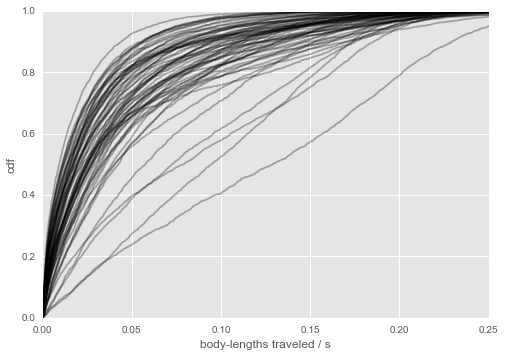

In [8]:
print 'young worms'

fig, ax = plt.subplots()
for track in young_tracks:
    speed = young_tracks[track]
    ax.plot(*make_cdf(speed), color='black', alpha=0.3)
ax.set_xlim([0, 0.25])
ax.set_ylabel('cdf')
ax.set_xlabel('body-lengths traveled / s')
plt.show()

In [9]:
def track_dict_to_ks_df(tdict):
    at = tdict.keys()
    df = pd.DataFrame(index=at, columns=at, dtype=float)
    for bid in at:
        df.ix[bid, bid] = 1
    for (bid1, bid2) in itertools.combinations(at, 2):
        s1 = tdict[bid1]
        s2 = tdict[bid2]
        ks_stat, p_ks = stats.ks_2samp(s1, s2)
        df.ix[bid1, bid2] = p_ks
        df.ix[bid2, bid1] = p_ks
    return df
young_df = track_dict_to_ks_df(young_tracks)

In [10]:
c = ClusterMatrix(np.array(young_df))
(data, order) = c.deep_sort(cooling_factor=0.96, verbose=False, finishing_criterion=3)

../../../pybrary/pat_cluster/sort.py:76: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if array == None:


day1 worms


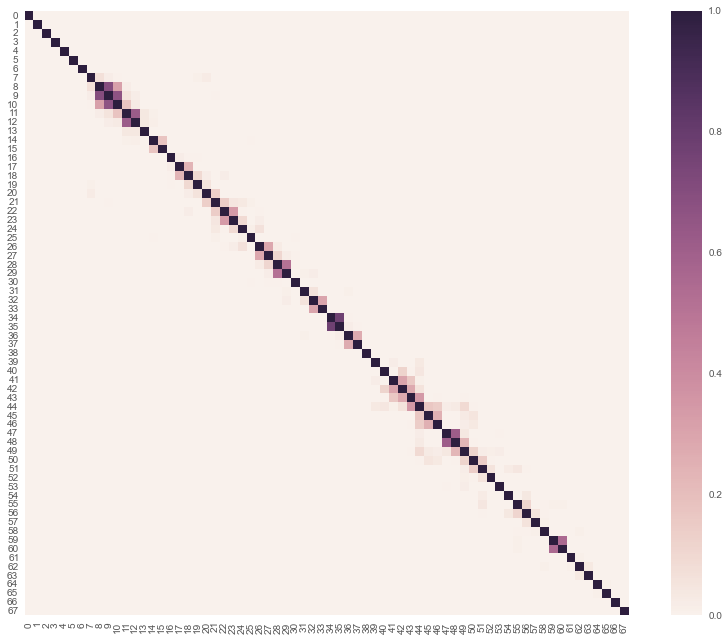

In [11]:
print 'day1 worms'
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data, vmax=1.0, linewidths=0, square=True)

f.tight_layout()

day1 worms


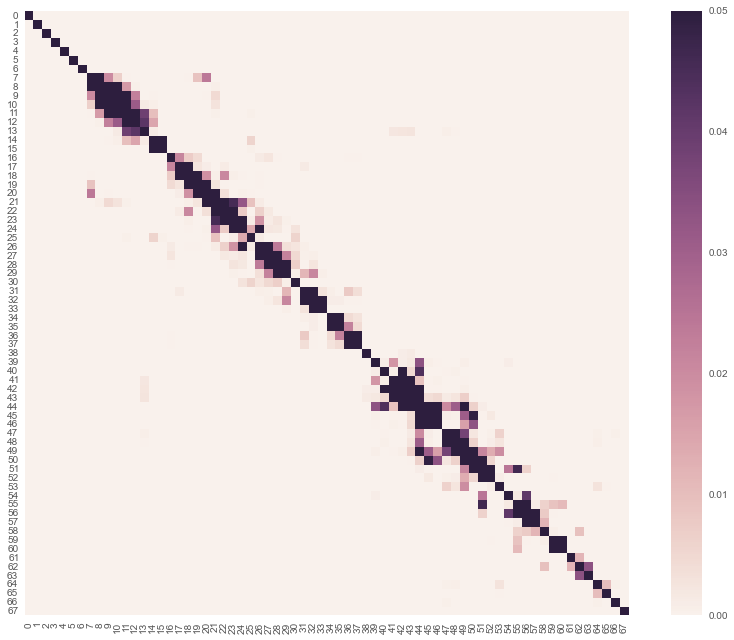

In [12]:
print 'day1 worms'
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data, vmax=0.05, linewidths=0, square=True)

f.tight_layout()

In [13]:
day_6_eids = ['20130323_132232', 
              '20130323_132238', 
              '20130323_132240', 
              '20130323_143659', 
              '20130323_143706', 
              '20130323_143707']

old_tracks = {}
for eid in day_6_eids:
    try:
        eid_tracks = pull_tracks(eid)
        old_tracks.update(eid_tracks)
        print eid, '-', len(eid_tracks), 'tracks'
    except MWTSummaryError:
        print eid, '- skipping'
        
print len(old_tracks), 'tracks in total'
old_df = track_dict_to_ks_df(old_tracks)

20130323_132232 - 12 tracks
20130323_132238 - skipping
20130323_132240 - 6 tracks
20130323_143659 - 16 tracks
20130323_143706 - 7 tracks
20130323_143707 - 8 tracks
49 tracks in total


old worms


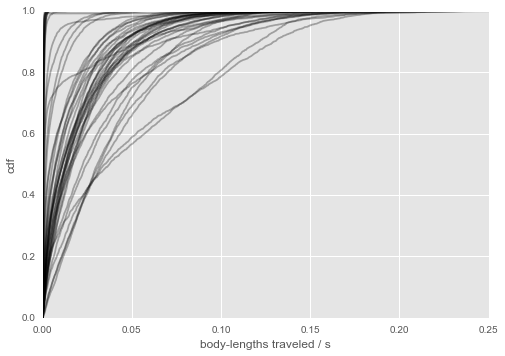

In [14]:
print 'old worms'
fig, ax = plt.subplots()
for track in old_tracks:
    speed = old_tracks[track]
    ax.plot(*make_cdf(speed), color='black', alpha=0.3)
ax.set_ylabel('cdf')
ax.set_xlabel('body-lengths traveled / s')
ax.set_xlim([0, 0.25])
plt.show()

In [15]:
current_palette = sns.color_palette()
current_palette

[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
 (0.596078431372549, 0.5568627450980392, 0.8352941176470589),
 (0.4666666666666667, 0.4666666666666667, 0.4666666666666667),
 (0.984313725490196, 0.7568627450980392, 0.3686274509803922),
 (0.5568627450980392, 0.7294117647058823, 0.25882352941176473)]

In [16]:
import matplotlib.colors

In [17]:
from matplotlib.colors import LogNorm

In [19]:
c2 = ClusterMatrix(np.array(old_df))
(data2, order2) = c2.deep_sort(cooling_factor=0.96, verbose=False, finishing_criterion=3)

day6 worms
49


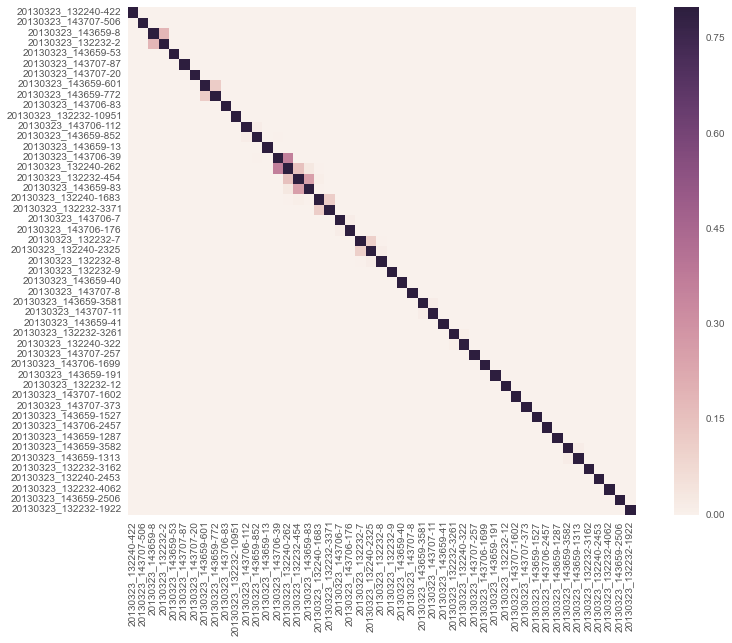

In [20]:
print 'day6 worms'
print len(old_df)
index_sorted = old_df.index[[order2]]
old_sorted = pd.DataFrame(data2, index=index_sorted, columns=index_sorted)
#norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()), cmap='PuBu_r'

f, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(old_sorted, vmax=.8, linewidths=0.0, square=True)
f.tight_layout()

day6 worms


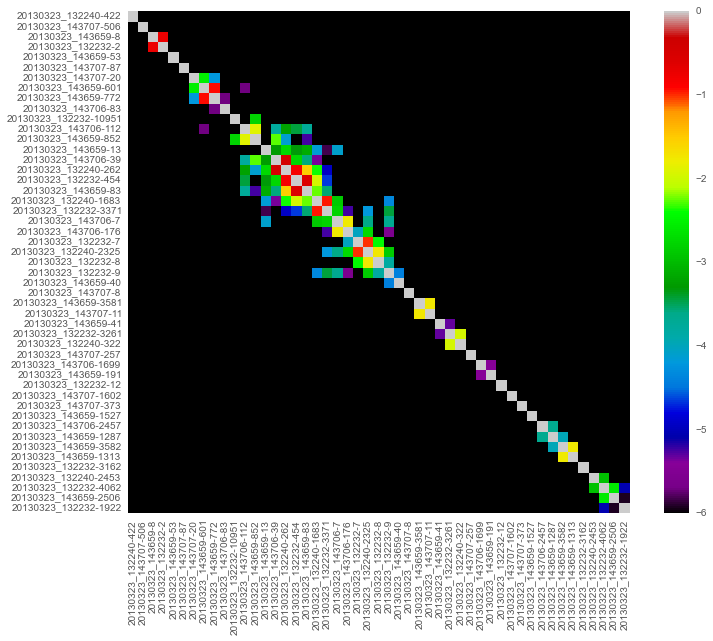

In [30]:
print 'day6 worms'

index_sorted = old_df.index[[order2]]
old_sorted = pd.DataFrame(data2, index=index_sorted, columns=index_sorted)
#old_sorted[old_sorted==0] = vmin
#norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()), cmap='PuBu_r'

f, ax = plt.subplots(figsize=(12, 9))
#cp = sns.diverging_palette(10, 220, sep=80, n=13)
ax = sns.heatmap(np.log10(old_sorted), vmin=-6, vmax=0, linewidths=0.0, square=True, 
                 #norm=LogNorm(), cbar=False,
                 cmap='spectral'
)


PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
#plt.colorbar(PCM, ax=ax) 
#plt.colorbar(plt.imshow(data2), norm=LogNorm(), cmap='spectral')
#f.tight_layout()

In [22]:
ax.get_children()[2]


example of matching distributions


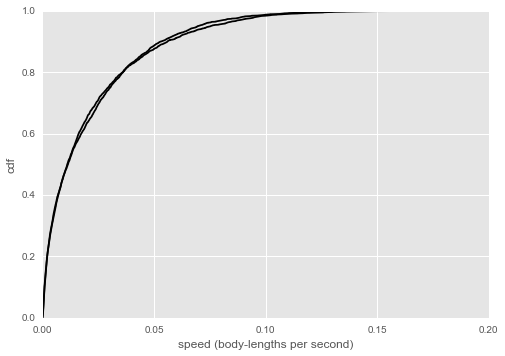

In [23]:
eids = ['20130323_132232-454', '20130323_143659-83']
print 'example of matching distributions'
fig, ax = plt.subplots()
for eid in eids:
    ax.plot(*make_cdf(old_tracks[eid]), color='black')
ax.set_ylabel('cdf')
ax.set_xlabel('speed (body-lengths per second)')
plt.show()

example of non-matching distributions


KeyError: '20130323_143659-701'

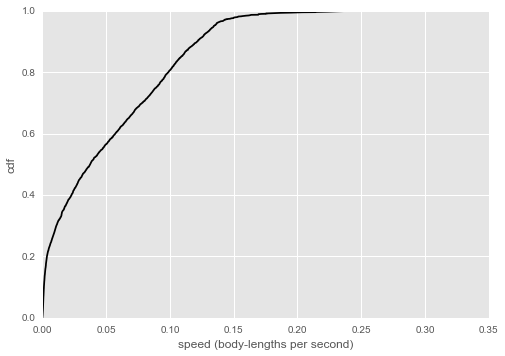

In [24]:
#old_sorted[old_sorted > 0.05]
#for eid in old_sorted.index:
#    print eid
print 'example of non-matching distributions'
eids = ['20130323_132232-12', '20130323_143659-701']
fig, ax = plt.subplots()
for eid in eids:
    ax.plot(*make_cdf(old_tracks[eid]), color='black')
    ax.set_ylabel('cdf')
    ax.set_xlabel('speed (body-lengths per second)')
plt.show()

In [31]:
all_tracks = {}
all_tracks.update(old_tracks)
all_tracks.update(young_tracks)
print len(all_tracks)
all_df = track_dict_to_ks_df(all_tracks)

117


In [32]:
c = ClusterMatrix(np.array(all_df))
(data3, order3) = c.deep_sort(cooling_factor=0.96, verbose=False, finishing_criterion=3)

all worms
117


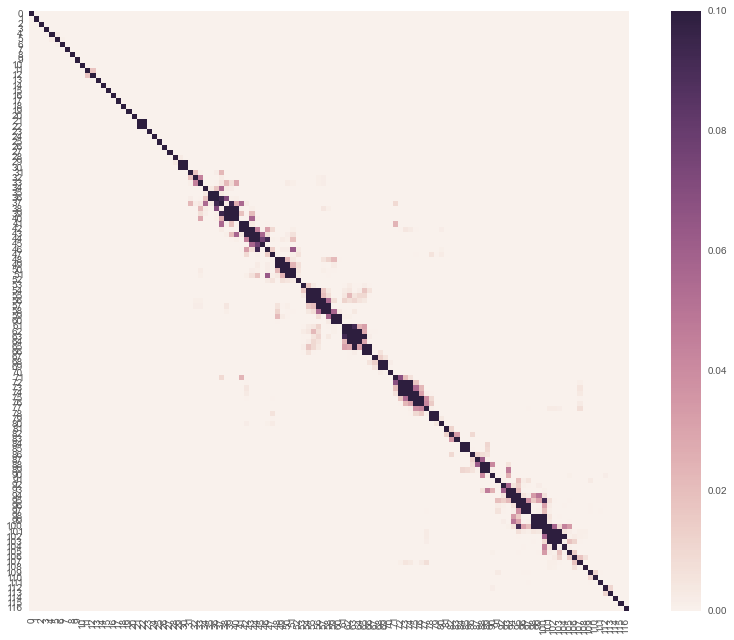

In [33]:
print 'all worms'
print len(all_df)

#index_sorted = all_df.index[[order3]]
#all_sorted = pd.DataFrame(data3, index=index_sorted, columns=index_sorted)
#norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()), cmap='PuBu_r'

f, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(data3, vmax=.1, linewidths=0.0, square=True)
f.tight_layout()

old v young worms


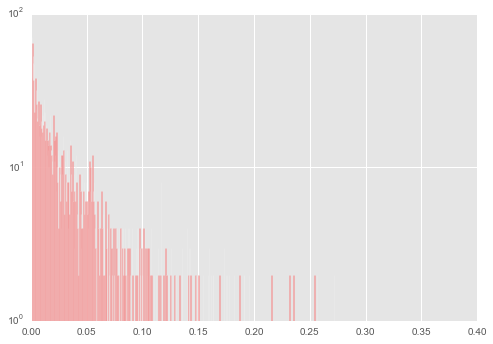

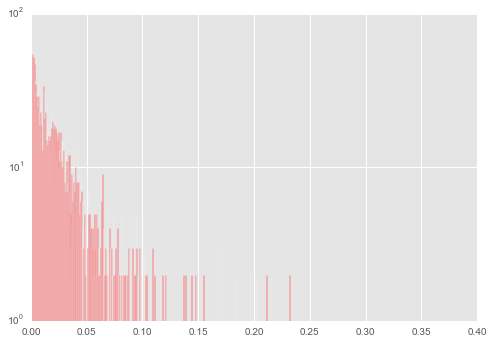

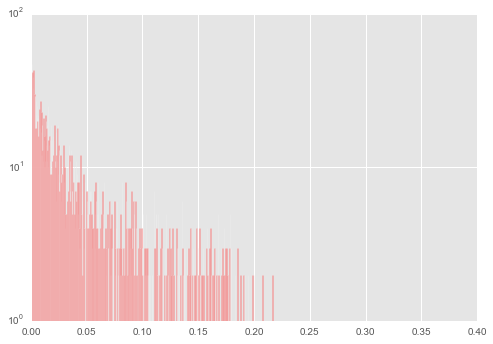

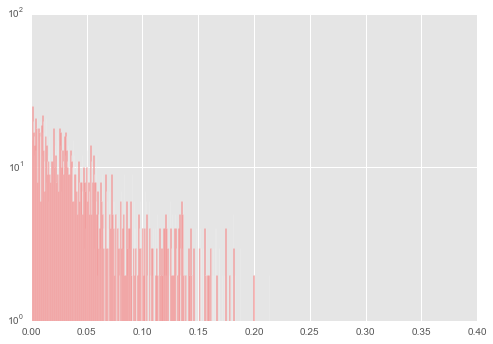

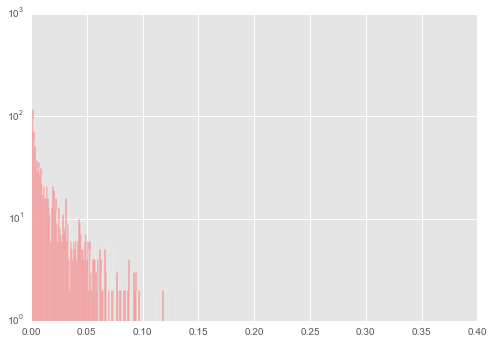

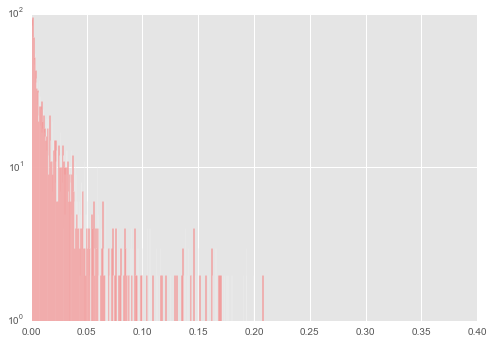

In [41]:
print 'old v young worms'
# fig, ax = plt.subplots()
# for track in old_tracks:
#     speed = old_tracks[track]
#     ax.plot(*make_cdf(speed), color='blue', alpha=0.2)
i = 0
for track in young_tracks:
    speed = young_tracks[track]
    #ax.plot(*make_cdf(speed), color='red', alpha=0.2) 
    fig, ax = plt.subplots()
    ax.hist(*make_cdf(speed), color='red', alpha=0.8) 
    ax.set_yscale('log')
    ax.set_xlim([0, 0.4])

    plt.show()
    i +=1
    if i >5:
        break
ax.set_ylabel('cdf')
ax.set_xlabel('body-lengths traveled / s')
ax.set_xlim([0, 0.25])
plt.show()

In [75]:
#from scipy.optimize import curve_fit, minimize
#plt.plot(speed)
#plt.show()

In [158]:
def fit_exponential_to_data(s, ax=None, bins=100):
    loc, scale = stats.expon.fit(s)
    print 'loc', loc
    print 'scale', scale
    dist = stats.expon(loc=loc, scale=scale)
    
    if ax:    
        x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), bins)
        #fig, ax = plt.subplots()
        ax.hist(s, bins=x, normed=True)
        ax.plot(x, dist.pdf(x),'r-', lw=5, alpha=0.6, label='expon pdf', color='black')
    #plt.show()


    log_likelyhood = np.log(dist.pdf(s)).sum()
    print 'log_likelyhood', log_likelyhood
    return loc, scale

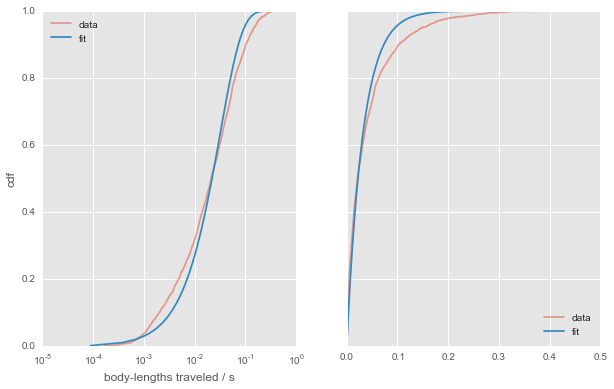

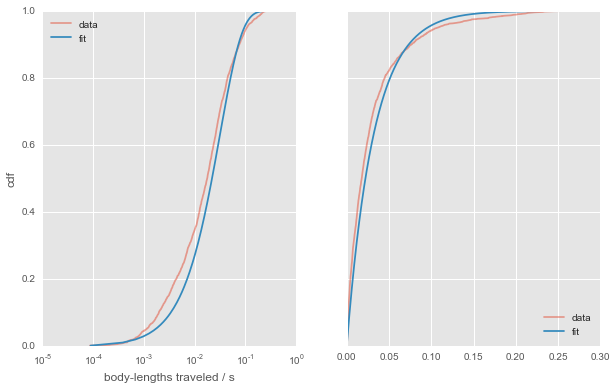

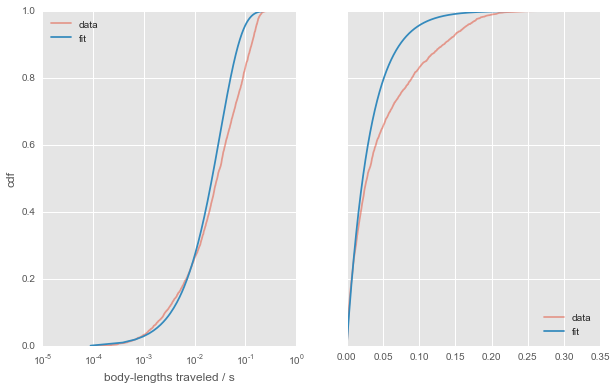

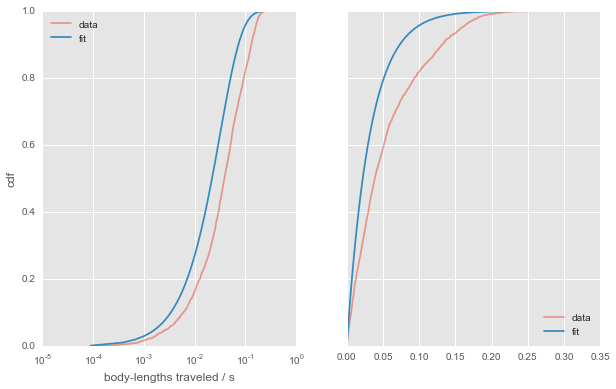

In [188]:
i = 0
for track in young_tracks:
    speed = young_tracks[track]
    
    fig, ax = plt.subplots(1, 2, sharey=True)
    
    loc, scale = stats.expon.fit(s)
    dist = stats.expon(loc=loc, scale=scale)
    x = np.linspace(dist.ppf(0.0001), dist.ppf(0.9999), 1000)
    
    ax[0].plot(*make_cdf(speed), alpha=0.5, label='data')
    ax[0].plot(x, dist.cdf(x), label='fit')
    ax[0].set_xscale('log')
    ax[1].plot(*make_cdf(speed), alpha=0.5, label='data')
    ax[1].plot(x, dist.cdf(x),  label='fit')
    
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='lower right')
    
    ax[0].set_ylabel('cdf')
    ax[0].set_xlabel('body-lengths traveled / s')
    #fit_exponential_to_data(speed, ax=ax[2])
    #ax[1].set_xlim([0, 0.25]
    
    plt.show()
    i +=1
    if i >3:
        break

plt.show()

loc 0.000171633779185
scale 0.0407358709901
log_likelyhood 6845.94135059


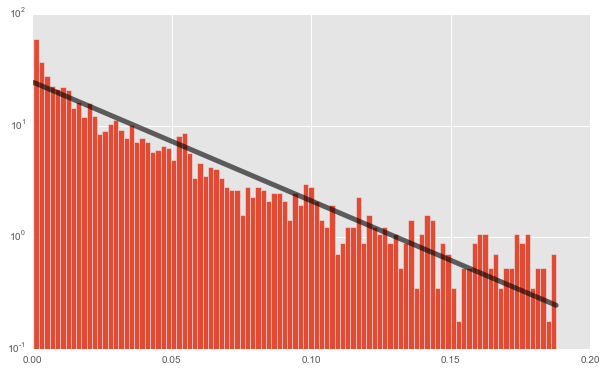

loc 8.72246754466e-05
scale 0.0306849631154
log_likelyhood 6943.81702338


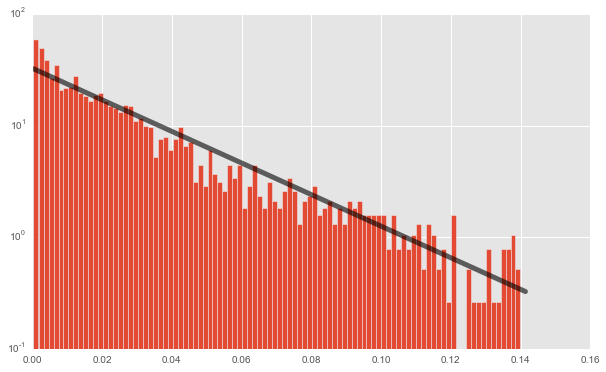

loc 0.000111062350493
scale 0.0488656313313
log_likelyhood 7000.60908428


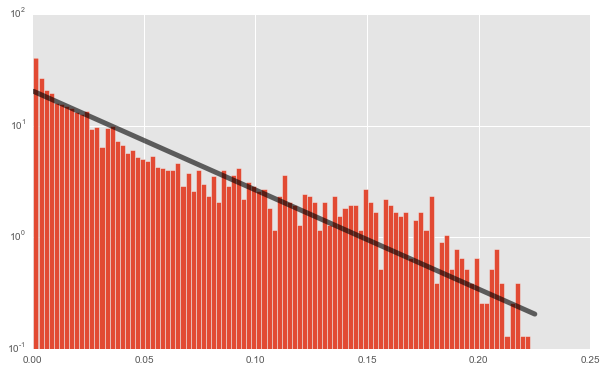

loc 0.000103529957976
scale 0.0547917100459
log_likelyhood 5356.83427966


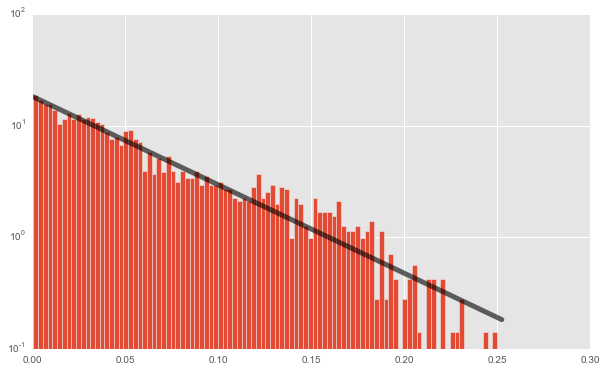

loc 2.54715697085e-05
scale 0.0213929495269
log_likelyhood 7481.46866701


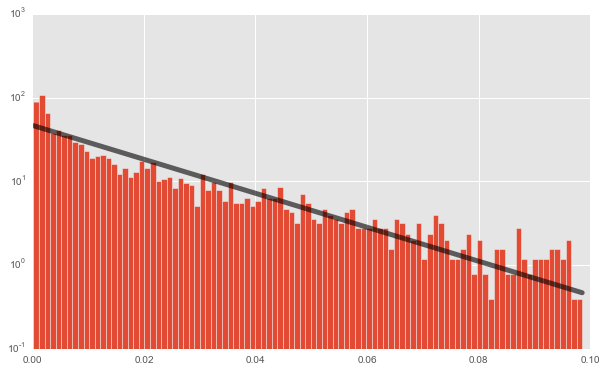

loc 8.59801435268e-05
scale 0.031863496622
log_likelyhood 8535.700085


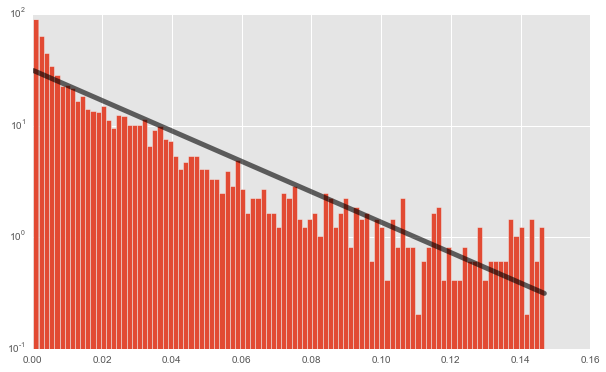

In [160]:
i = 0
for track in young_tracks:
    speed = young_tracks[track]
    #ax.plot(*make_cdf(speed), color='red', alpha=0.2) 
    fig, ax = plt.subplots()
    #ax.hist(speed, color='red', alpha=0.8) 
    loc, scale = fit_exponential_to_data(speed, ax=ax)
    ax.set_yscale('log')
    #ax.set_xlim([0, 0.4])

    plt.show()
    i +=1
    if i >5:
        break
ax.set_ylabel('cdf')
ax.set_xlabel('body-lengths traveled / s')
ax.set_xlim([0, 0.25])
plt.show()

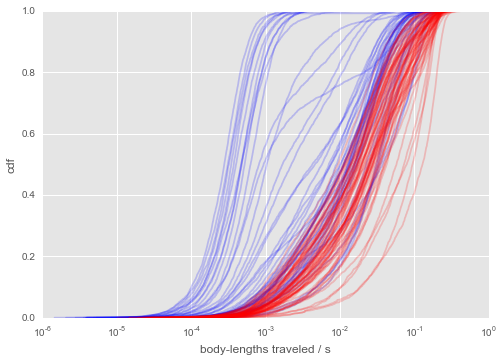

In [35]:
fig, ax = plt.subplots()
for track in old_tracks:
    speed = old_tracks[track]
    ax.plot(*make_cdf(speed), color='blue', alpha=0.2)
for track in young_tracks:
    speed = young_tracks[track]
    ax.plot(*make_cdf(speed), color='red', alpha=0.2)    
ax.set_ylabel('cdf')
ax.set_xlabel('body-lengths traveled / s')
#ax.set_xlim([0, 0.25])
ax.set_xscale('log')
plt.show()